## Convert ATL10 files into shapefiles

### Convert ATL10 files into ESRI Shapefiles

In [1]:
## Check available ATL03 data over Ross Sea and convert to csv files

import os, sys
import h5py
from glob import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
import scipy.signal
import datetime as dt
import pandas as pd
import netCDF4
import time
from functions_floes import *

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# make sure we're dealing with the most recent version of any code we're using
%load_ext autoreload
%autoreload 2

# from readers.get_ATL10 import get_ATL10data
# from readers.get_ATL07 import get_ATL07


In [57]:
for year in [2019, 2020, 2021, 2022]:
    
    df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{year}.csv", index_col = 0)
    
    bbox = [-65, -77.6, -15, -62]

    if year == 2019:
        th = 20
    else:
        th = 8
    
    ib_count = df_all.groupby(by=['filename', 'beam'], as_index = False).count()
    ib_many = ib_count[ib_count["fb_mean"] > th].reset_index(drop = True)

    print(len(ib_many))
    
    for i in tqdm(range(0, len(ib_many))):
        
        filename = ib_many.loc[i, "filename"]
        beam = ib_many.loc[i, "beam"]
        
        with h5py.File("D:\\Floes\\ATL10\\" + filename, 'r') as f:
            # print(filename)
            # Check the orbit orientation
            orient = f['orbit_info/sc_orient'][0]
    
            lat = f[beam]['freeboard_segment/latitude'][:]
            lon = f[beam]['freeboard_segment/longitude'][:]
            fb = f[beam]['freeboard_segment/beam_fb_height'][:]
    
            idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 100) & (fb >= 1)
    
            if any(idx):
                lat = lat[idx]
                lon = lon[idx]
                fb = fb[idx]
        
                seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
                seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
                ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
                sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
                # fb[fb > 100] = np.nan
                stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
                refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
                fb_std = pd.Series(fb).rolling(3, center = True).std().values
        
                df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb,
                                   'fb_std': fb_std, 'ph_rate': ph_rate, 'sigma': sigma})
    
                shpname = filename.replace(".h5", "_"+beam+".shp")
                outfile = f"D:\\Floes\\icebergs\\shpfiles\\{shpname}"
                convertshp(df, outfile)

22


100%|██████████| 22/22 [01:50<00:00,  5.04s/it]


13


100%|██████████| 13/13 [00:40<00:00,  3.10s/it]


13


100%|██████████| 13/13 [00:43<00:00,  3.38s/it]


9


100%|██████████| 9/9 [00:35<00:00,  3.94s/it]


In [8]:
orient

0

In [10]:
## Convert ATL10 files on Mar 13 (Sentinel-2 image date) to shapefiles
files = glob.glob("D:\\Floes\\ATL10\\ATL10-02_20190313*.h5")
bbox = [-65, -77.6, -15, -62]

print(files)

for filename in files:

    with h5py.File(filename, 'r') as f:
        # print(filename)
        # Check the orbit orientation
        orient = f['orbit_info/sc_orient'][0]

        if (orient == 0):
            beams=['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']                
        elif (orient == 1):
            beams=['gt3r', 'gt3l', 'gt2r', 'gt2l', 'gt1r', 'gt1l']
        # (strong, weak, strong, weak, strong, weak)
        # (beam1, beam2, beam3, beam4, beam5, beam6)

        beams = [ beams[i] for i in [0, 2, 4] ]

        for beam in beams:
            lat = f[beam]['freeboard_segment/latitude'][:]
            lon = f[beam]['freeboard_segment/longitude'][:]
            fb = f[beam]['freeboard_segment/beam_fb_height'][:]
        
            idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 100) & (fb >= 1)
        
            if any(idx):
                lat = lat[idx]
                lon = lon[idx]
                fb = fb[idx]
        
                seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
                seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
                ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
                sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
                # fb[fb > 100] = np.nan
                stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
                refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
                fb_std = pd.Series(fb).rolling(3, center = True).std().values
        
                df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb,
                                   'fb_std': fb_std, 'ph_rate': ph_rate, 'sigma': sigma})
        
                shpname = os.path.basename(filename).replace(".h5", "_"+beam+".shp")
                outfile = f"D:\\Floes\\icebergs\\shpfiles\\{shpname}"
            convertshp(df, outfile)

['D:\\Floes\\ATL10\\ATL10-02_20190313094723_11450201_006_02.h5', 'D:\\Floes\\ATL10\\ATL10-02_20190313112140_11460201_006_02.h5', 'D:\\Floes\\ATL10\\ATL10-02_20190313204725_11520201_006_02.h5', 'D:\\Floes\\ATL10\\ATL10-02_20190313222142_11530201_006_02.h5']


In [133]:
filename = "D:\\Floes\\ATL10\\ATL10-02_20220726002820_05211601_006_02.h5"
beam_num = 1

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 10)

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
        fb_std = pd.Series(fb).rolling(3, center = True).std().values

        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb,
                           'fb_std': fb_std, 'ph_rate': ph_rate, 'sigma': sigma})

        ib_mask = (fb > 1.0) & (sigma < 0.03) & (fb_std < 0.1)
        ib_mask2, df_ib = determine_iceberg(df, ib_mask)
        df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2)

print(filename)

D:\Floes\ATL10\ATL10-02_20220726002820_05211601_006_02.h5


D:\Floes\ATL10\ATL10-02_20220726002820_05211601_006_02.h5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


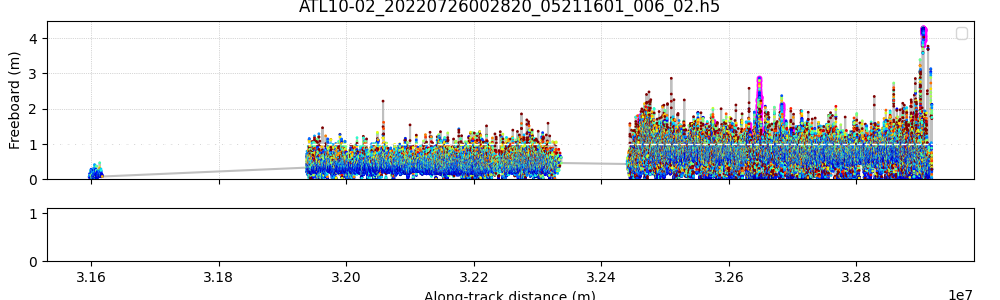

In [134]:
%matplotlib widget
print(filename)
fig, ax = plt.subplots(2,1, figsize = (10, 3), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax[0].scatter(seg_x[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax[0].errorbar(df_ib2['lat'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
# fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

ax[0].set_ylim(0, 4.5);

ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

In [2]:
for year in [2019]:
    
    df = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{year}.csv", index_col = 0)
    
    bbox = [-65, -77.6, -15, -62]
    xstep = 1.0
    ystep = 0.4
    x0 = np.arange(bbox[0], bbox[2], xstep) # Lon
    y0 = np.arange(bbox[1], bbox[3], ystep) # lat

    xx, yy = np.meshgrid(y0, x0)
    months = df['month'].unique()

    frq = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    frq_len = np.zeros((len(months), xx.shape[0], xx.shape[1]))

    for i, x in enumerate(x0):
        for j, y in enumerate(y0):
            for k, m in enumerate(months):
                df0 = df[(df['lon']>x-xstep/2) & (df['lon']<x+xstep/2) & (df['lat']>y-ystep/2) & (df['lat']<y+ystep/2) & (df['month']==m)]
                frq[k, i, j] = len(df0)
                frq_len[k, i, j] = np.sum(df0['width'])
            
    print(year)

2019


3

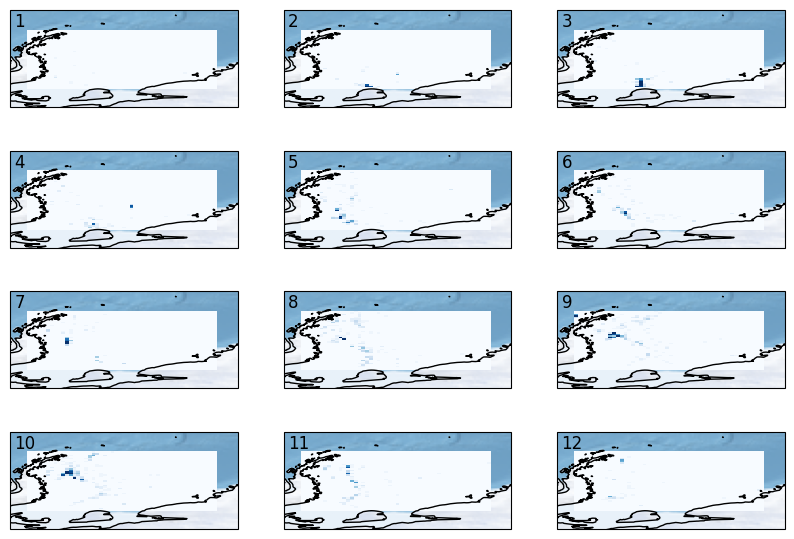

In [52]:
%matplotlib inline
fig, ax = plt.subplots(4,3,subplot_kw={'projection': ccrs.PlateCarree()}, dpi = 100, figsize = (10,7))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].coastlines(linewidth = 1, color = "k")
        y1, y2 = ax[i,j].set_xlim(bbox[0]-5, bbox[2]+5)
        y1, y2 = ax[i,j].set_ylim(bbox[1]-5, bbox[3]+5)
        ax[i,j].stock_img()
        n = i*3+j%4
        ax[i,j].pcolormesh(yy, xx, frq[n], vmax=20, cmap = "Blues")
        ax[i,j].annotate(int(n+1), xy=(0.02, 0.97), xycoords='axes fraction', fontsize=12, ha='left', va='top')
        # plt.colorbar()

plt.show()